# Implementation of Logistic Regression from Scratch

Just like we learned how to implement linear regression from scratch, it is very instructive to do the same for logistic regression. We begin with our regular import ritual.

In [1]:
import os
import sys
import random
%matplotlib inline

from sklearn.datasets.samples_generator import make_blobs, make_moons, make_circles
from sklearn.model_selection import train_test_split
import numpy as np
np.seterr(all='raise')
np.random.seed(0)
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from mpl_toolkits.mplot3d.axes3d import Axes3D
plt.style.use('classic')

from IPython.display import HTML

We use the Fashion-MNIST data set with batch size 256.

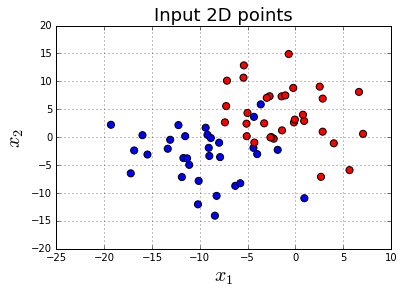

In [2]:
def data_iter(batch_size, features, labels):
    num_examples = len(features)
    indices = list(range(num_examples))
    # The examples are read at random, in no particular order
    random.shuffle(indices)
    for i in range(0, num_examples, batch_size):
        j = np.array(indices[i: min(i + batch_size, num_examples)])
        yield features.take(j, axis=0), labels.take(j, axis=0)
        # The “take” function will then return the corresponding element based
        # on the indices

X, y = make_blobs(n_samples=64, centers=2, n_features=2, cluster_std=5, random_state=1)
# X, y = make_moons(n_samples=64, random_state=1)
# X, y = make_circles(n_samples=64, random_state=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)

batch_size = 32

colormap = np.array(['r', 'b'])

def plot_scatter(X, y):
    plt.grid()
    plt.xlabel('$x_1$', size=20)
    plt.ylabel('$x_2$', size=20)
    plt.title('Input 2D points', size=18)
    plt.scatter(X[:,0], X[:, 1], s=50, c=colormap[y])
    
plot_scatter(X, y)

## Initialize Model Parameters

Just as in linear regression, we use vectors to represent examples. Since each example has $2$ features we can store it as a $2$ dimensional vector. Moreover, since we have 2 categories, the single layer network has an output dimension of 1. Consequently, the weight and bias parameters of the logistic regression are matrices of size $2 \times 1$ and $1 \times 1$ respectively. We initialize $W$ with Gaussian noise.

In [3]:
num_inputs = X.shape[1]
num_outputs = 1

W = np.random.normal(scale=0.05, loc=0, size=(num_inputs, num_outputs))
b = np.zeros(num_outputs)

## The Logistic

For that we first exponentiate each term using `exp` and then add it with one. Last we divide one by it and return the result. Before looking at the code, let's look at this in equation form:

$$
\mathrm{logistic}(\mathbf{X})_{i} = \frac{1}{1+e^{-X_{i}}}
$$

In [4]:
def logistic(X):
    # TODO: implement logistic function with numpy exp function
    ans=1/(1+np.exp(-X))
    return ans

## The Model

With the logistic operation, we can define the logistic regression model discussed in the last section.

In [5]:
def net(X):
    return logistic(np.dot(X, W) + b)

## The Loss Function

We introduced the cross-entropy loss function used by logistic regression. It may be the most common loss function you’ll find in all of deep learning. That’s because at the moment, classification problems tend to be far more abundant than regression problems.

Recall that it picks the label's predicted probability and takes its logarithm $-\log p(y|x)$. Rather than having to do this using a Python `for` loop (which tends to be inefficient) we have a `pick` function which allows us to select the appropriate terms from the matrix of logistic entries easily. We illustrate this in the case of 3 categories and 2 examples.

In [6]:
y_hat = np.array([[0.1, 0.3, 0.6], [0.3, 0.2, 0.5]])
y = np.array([0, 2], dtype='int32')
y_hat[np.arange(y_hat.shape[0]), y]

array([0.1, 0.5])

This yields the cross-entropy loss function.

In [7]:
def cross_entropy(y_hat, y):
    delta = 1e-8
    return - (y.reshape(y_hat.shape) * np.log(y_hat + delta) + (1 - y.reshape(y_hat.shape)) * np.log(1 - y_hat + delta)).mean()

## Classification Accuracy

Given a class of predicted probability distributions `y_hat`, we use the one with the highest predicted probability as the output category. If it is consistent with the actual category `y`, then this prediction is correct.  The classification accuracy is the ratio between the number of correct predictions and the total number of predictions made.

To demostrate how to compute accuracy, the function `accuracy` is defined as follows: `y_hat.argmax(axis=1)` returns the largest element index to matrix `y_hat`, the result has the same shape as variable `y`. Now all we need to do is check whether both match. Since the equality operator `==` is datatype-sensitive (e.g. an `int` and a `float32` are never equal), we also need to convert both to the same type (we pick `float32`). The result is an NDArray containing entries of 0 (false) and 1 (true). Taking the mean yields the desired result.

In [8]:
def accuracy(y_hat, y):
    return (y_hat.argmax(axis=1) == y.astype('float32')).mean()

We will continue to use the variables `y_hat` and `y` defined in the `pick` function, as the predicted probability distribution and label, respectively. We can see that the first example's prediction category is 2 (the largest element of the row is 0.6 with an index of 2), which is inconsistent with the actual label, 0. The second example's prediction category is 2 (the largest element of the row is 0.5 with an index of 2), which is consistent with the actual label, 2. Therefore, the classification accuracy rate for these two examples is 0.5.

In [9]:
accuracy(y_hat, y)

0.5

Similarly, we can evaluate the accuracy for model `net` on the data set `data_iter`.

In [10]:
def evaluate_accuracy(data_iter, net):
    acc_sum, n = 0.0, 0
    for X, y in data_iter:
        y = y.astype('float32')
        y_hat = net(X)
        acc_sum += ((y_hat >= 0.5) == y.reshape(y_hat.shape)).sum()
        n += y.shape[0]
    return acc_sum / (n + 1e-8)

Because we initialized the `net` model with random weights, the accuracy of this model should be close to random guessing, i.e. 0.1 for 10 classes.

In [11]:
evaluate_accuracy(data_iter(batch_size, X_test, y_test), net)

0.15624999995117186

## Model Training

The implementation for training softmax regression is very similar to the implementation of linear regression discussed earlier. We still use the mini-batch stochastic gradient descent to optimize the loss function of the model. When training the model, the number of epochs, `num_epochs`, and learning rate `lr` are both adjustable hyper-parameters. By changing their values, we may be able to increase the classification accuracy of the model.

epoch 1, loss 0.0288, train acc 0.344, test acc 0.312
epoch 2, loss 0.0254, train acc 0.406, test acc 0.406
epoch 3, loss 0.0227, train acc 0.438, test acc 0.531
epoch 4, loss 0.0207, train acc 0.625, test acc 0.750
epoch 5, loss 0.0191, train acc 0.812, test acc 0.844
epoch 6, loss 0.0179, train acc 0.844, test acc 0.875
epoch 7, loss 0.0170, train acc 0.844, test acc 0.844
epoch 8, loss 0.0162, train acc 0.844, test acc 0.844
epoch 9, loss 0.0156, train acc 0.844, test acc 0.844
epoch 10, loss 0.0152, train acc 0.812, test acc 0.844
epoch 11, loss 0.0148, train acc 0.812, test acc 0.844
epoch 12, loss 0.0144, train acc 0.812, test acc 0.844
epoch 13, loss 0.0141, train acc 0.812, test acc 0.844
epoch 14, loss 0.0139, train acc 0.812, test acc 0.844
epoch 15, loss 0.0136, train acc 0.812, test acc 0.844
epoch 16, loss 0.0135, train acc 0.812, test acc 0.844
epoch 17, loss 0.0133, train acc 0.812, test acc 0.844
epoch 18, loss 0.0131, train acc 0.812, test acc 0.844
epoch 19, loss 0.01

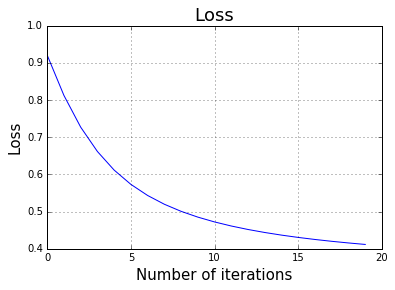

In [12]:
num_epochs, lr = 20, 1e-2

w_cache = []
b_cache = []
# TODO: define an empty list to store the loss history
l_cache = []

def sgd(lr, batch_size, w_grad, b_grad):
    global W, b
    W = W - lr * w_grad / batch_size
    b = b - lr * b_grad / batch_size

def train_ch3(net, loss, num_epochs, batch_size, params=None, lr=None, trainer=None):
    for epoch in range(num_epochs):
        train_l_sum, train_acc_sum, n = 0.0, 0.0, 0
        for X, y in data_iter(batch_size, X_train, y_train):
            y_hat = net(X)
            l = loss(y_hat, y).sum()
            w_grad =  np.dot(X.T,(y_hat-y.reshape(y_hat.shape)))
            b_grad = (y_hat - y.reshape(y_hat.shape)).sum()
            sgd(lr, batch_size, w_grad, b_grad)
            y = y.astype('float32')
            train_l_sum += l
            train_acc_sum += ((y_hat >= 0.5) == y.reshape(y_hat.shape)).sum()
            n += y.shape[0]
            
        test_acc = evaluate_accuracy(data_iter(batch_size, X_test, y_test), net)
        print('epoch %d, loss %.4f, train acc %.3f, test acc %.3f'
              % (epoch + 1, train_l_sum / n, train_acc_sum / n, test_acc))
        
        w_cache.append(W.copy().reshape(-1))
        b_cache.append(b.copy())
        l_cache.append(train_l_sum)  

def plot_loss(loss_cache):
    plt.grid()
    plt.title('Loss', size=18)
    plt.xlabel('Number of iterations', size=15)
    plt.ylabel('Loss', size=15)
    ###########################################################################################
    # TODO: use the plot function in matplotlib.pyplot to plot the loss curve
    ###########################################################################################
    plt.plot(range(num_epochs),l_cache)
    ###########################################################################################   
    
train_ch3(net, cross_entropy, num_epochs, batch_size, [W, b], lr)
plot_loss(l_cache)

## Summary

We can use logistic regression to carry out binary category classification. Training is very similar to that of linear regression: retrieve and read data, define models and loss functions, then train models using optimization algorithms. In fact, most common deep learning models have a similar training procedure.